#Фролов Владимир
**Stepik User ID: 541150734**

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
import random
from pathlib import Path
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import pickle
from PIL import Image
from time import time
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing). Я датасет брал [отсюда](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small).

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
# !gdown -q --fuzzy https://drive.google.com/file/d/14OOVc5BxDUrlSXNSQPtp7DNii--7EGxh/view?usp=sharing
!unzip -q /content/gdrive/My\ Drive/GAN/archive -d faces_dataset
!mv faces_dataset/faces_dataset_small faces_dataset/images

Определим пути к папкам для сохранеия весов модели, логов, промежуточных результатов обучения

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/GAN'
M_WEIGHTS = '/content/gdrive/MyDrive/GAN/model_weights'
M_LOGS = '/content/gdrive/MyDrive/GAN/logs'
GEN_FACES = '/content/gdrive/MyDrive/GAN/gen_faces'
FACES = Path('faces_dataset')

In [ ]:
os.makedirs(M_WEIGHTS, exist_ok=True)
os.makedirs(M_LOGS, exist_ok=True)
os.makedirs(GEN_FACES, exist_ok=True)
os.makedirs(FACES, exist_ok=True)

In [ ]:
for address, dirs, files in os.walk('/content/faces_dataset/images'):
  print(address, dirs, len(files))

/content/faces_dataset/images [] 3143


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Mon Dec 26 19:58:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

Препроцессим изображения, сохраняем в тензор

In [ ]:
image_size = 128
batch_size = 64
img_num = len(list(FACES.rglob('*.png')))

transforms = tt.Compose([
    tt.Resize(image_size, interpolation=tt.InterpolationMode.BICUBIC),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

preprocessed_files = torch.empty(size=(img_num, 3, image_size, image_size))
idx = 0
for dirpath, dirnames, filenames in os.walk(FACES):
        for fname in filenames:
            if fname.endswith(".png"):
                temp_img = Image.open(os.path.join(dirpath,fname))
                preprocessed_files[idx] = transforms(temp_img)
                idx += 1

Создадим класс, чтобы отражать изображения по горизонтали

In [ ]:
class Flip(Dataset):
    def __init__(self, images):
        super().__init__()
        self.trf = tt.Compose([
            tt.RandomHorizontalFlip()
        ])
        self.images = images
    def __getitem__(self, idx):
        return self.trf(self.images[idx])
    def __len__(self):
        return len(self.images)

In [ ]:
faces_dataset = Flip(preprocessed_files)
dl = DataLoader(faces_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Напишем вспомогательные функции (как в семинаре): to_device и класс DeviceDataLoader

In [ ]:
def to_device(data, device):
    """Переносим тензоры на выбранный девайс"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Это просто "обёртка" над стандартным даталоадером, позволяющая сразу перекидывать данные на девайс
class DeviceDataLoader():
    """Обёртка для лоадера: исходный лоадер и девайс передаем как аргументы"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Через yield получаем батч уже перекинутый на девайс"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Количество батчей"""
        return len(self.dl)

In [ ]:
faces_dataloader = DeviceDataLoader(dl, DEVICE)

Поскольку у нас изображения нормализованы к диапазону [-1, 1], а для визуализации их нужно привести к диапазону [0, 1], введем функцию денормализации

In [ ]:
def denorm(image):
    return image * 0.5 + 0.5

In [ ]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))

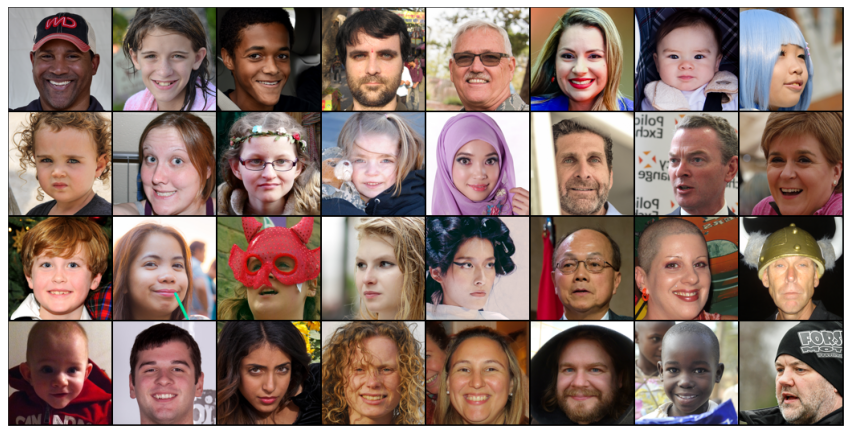

In [ ]:
x = next(iter(faces_dataloader))
show_images(x)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

1.    В классификаторе в каждом слое добавлен шум, что играет роль своеобразной регуляризации. В генераторе добавлены дропауты. Эти трюки взяты из статьи по GAN-хакам, оттуда же взята инфа про label smoothing.
2.    В качестве функции активации в генераторе и классификаторе использовалась LeakyReLU.
3.    Все свертки инициализированы нормальным распределением со средним 0 и стандартным отклонением 0.02. Значения рекомендованы в оригинальной статье по DCGAN.




In [ ]:
# Гауссовский шум, который будем добавлять к каждому слою классификатора
class GaussianNoise(nn.Module):
  def __init__(self, std=0.1):
    super().__init__()
    self.std = std

  def forward(self, x):
    if self.training:
      return x + torch.empty_like(x).normal_(std=self.std)
    else:
      return x

fl_channels = 64

# Классификатор(дискриминатор)
class Discriminator(nn.Module):
  def __init__(self, image_size, fl_channels):
    super(Discriminator, self).__init__()

    num_iters = int(np.log2(image_size) - 3)

    self.main = nn.Sequential(
        OrderedDict([
            ('gauss_1', GaussianNoise()),
            ('conv_1', nn.Conv2d(in_channels=3, out_channels=fl_channels,
                                 kernel_size=4, stride=2, padding=1, bias=False)),
            ('act_1', nn.LeakyReLU(negative_slope=0.2, inplace=True))
        ])
    )

    for i in range(num_iters):
      self.main.add_module(f'gauss_{i + 2}', GaussianNoise())
      self.main.add_module(f'conv_{i + 2}', nn.Conv2d(in_channels=fl_channels*2**i,
                                                      out_channels=fl_channels*2**(i+1),
                                                      kernel_size=4, stride=2,
                                                      padding=1, bias=False))
      self.main.add_module(f'batchnorm_{i + 2}', nn.BatchNorm2d(num_features=fl_channels*2**(i+1)))
      self.main.add_module(f'act_{i + 2}', nn.LeakyReLU(negative_slope=0.2, inplace=True))

    self.main.add_module('final_gaussian', GaussianNoise())
    self.main.add_module('final_conv', nn.Conv2d(in_channels=fl_channels*2**num_iters,
                                                 out_channels=1,kernel_size=4,
                                                 stride=1, padding=0, bias=False))
    self.main.add_module('flatten', nn.Flatten())
    self.main.add_module('sigmoid', nn.Sigmoid())

    for j in self.main.modules():
      if isinstance(j, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(j.weight.data, 0.0, 0.02)

  def forward(self, x):
    return self.main(x)

In [ ]:
latent_size = 128 # choose latent size

class Generator(nn.Module):
  def __init__(self, latent_size, image_size, fl_channels):
    super(Generator, self).__init__()

    num_iters = int(np.log2(image_size) - 3)

    self.main = nn.Sequential(
        OrderedDict([
            ('upconv_1', nn.ConvTranspose2d(in_channels=latent_size,
                                            out_channels=fl_channels*2**num_iters,
                                            kernel_size=4, stride=1, padding=0,
                                            bias=False)),
            ('batchnorm_1', nn.BatchNorm2d(num_features=fl_channels*2**num_iters)),
            ('act_1', nn.ReLU(inplace=True)),
            ('dropout_1', nn.Dropout2d(p=0.3))
        ])
    )

    for i in range(num_iters, 0, -1):
      self.main.add_module(f'upconv_{num_iters - i + 2}', nn.ConvTranspose2d(in_channels=fl_channels*2**(i),
                                                                             out_channels=fl_channels*2**(i-1),
                                                                             kernel_size=4, stride=2, padding=1,
                                                                             bias=False))
      self.main.add_module(f'batchnorm_{num_iters - i + 2}', nn.BatchNorm2d(num_features=fl_channels*2**(i-1)))
      self.main.add_module(f'act_{num_iters - i + 2}', nn.LeakyReLU(negative_slope=0.2, inplace=True))
      self.main.add_module(f'dropout_{num_iters - i + 2}', nn.Dropout2d(p=0.3))

    self.main.add_module(f'final_upconv', nn.ConvTranspose2d(in_channels=fl_channels, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False))
    self.main.add_module(f'tanh', nn.Tanh())

    for j in self.main.modules():
      if isinstance(j, (nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(j.weight.data, 0.0, 0.02)

  def forward(self, x):
    return self.main(x)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 3e-4

discriminator = Discriminator(image_size, fl_channels).to(DEVICE)
generator = Generator(latent_size, image_size, fl_channels).to(DEVICE)

fixed_latent = torch.randn(64, latent_size, 1, 1, device=DEVICE)


model = {
    'discriminator': discriminator,
    'generator': generator
}

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

optimizer = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(),
                                        lr=lr, betas=(0.5, 0.999)),
    'generator': torch.optim.Adam(model['generator'].parameters(),
                                    lr=lr, betas=(0.5, 0.999))
}

Функция сохранения сгенерированных избражений и, при необходимости, визуализации

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    if os.path.exists(os.path.join(GEN_FACES, fake_fname)):
      os.remove(os.path.join(GEN_FACES, fake_fname))

    save_image(denorm(fake_images), os.path.join(GEN_FACES, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.detach().cpu()), nrow=8).permute(1, 2, 0))

Функция визуализации результатов обучения

In [ ]:
def show_plots(fake_images, dict_metrics, epoch, start):
    images = denorm(fake_images[:8]).permute(0, 2, 3, 1).numpy()
    plt.figure(figsize=(20, 20))

    for i in range(8):
      plt.subplot(3, 8, i + 1)
      plt.axis("off")
      plt.imshow(images[i])

    plt.subplot(3,1,2)
    plt.plot(dict_metrics['losses_d'], '-')
    plt.plot(dict_metrics['losses_g'], '-')
    #plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses')

    plt.subplot(3,1,3)
    plt.plot(dict_metrics['real_scores'], '-')
    plt.plot(dict_metrics['fake_scores'], '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores')

    plt.suptitle(f"Epoch: {epoch + start} \
    Loss_generator: {dict_metrics['losses_g'][-1]:.4f} \
    loss_discriminator: {dict_metrics['losses_d'][-1]:.4f} \
    real_score: {dict_metrics['real_scores'][-1]:.4f} \
    fake_score: {dict_metrics['fake_scores'][-1]:.4f}",
                      fontsize=16)
    plt.tight_layout()
    plt.show();

Функция обучения

In [ ]:
def fit(model, criterion, optimizer, epochs, start_idx=1, smooth=0.1):
  since = time()
  model['discriminator'].train()
  torch.cuda.empty_cache()

  losses_d = []
  losses_g = []
  real_scores = []
  fake_scores = []

  sched_d = torch.optim.lr_scheduler.MultiStepLR(optimizer['discriminator'], milestones=[75,150,225,300], gamma=0.9)
  sched_g = torch.optim.lr_scheduler.MultiStepLR(optimizer['generator'], milestones=[150,225,300], gamma=0.9)
  pbar = trange(epochs, desc='Epoch:')

  for epoch in pbar:
    # Перевод генератора в режим обучения
    model['generator'].train()
    # Лоссы и скоры за одну эпоху
    loss_d_per_ep = []
    loss_g_per_ep = []
    real_score_per_ep = []
    fake_score_per_ep = []
    # Обучаем классификатор
    for real_images in faces_dataloader:
      # Обнуляем градиенты оптимизатора
      optimizer['discriminator'].zero_grad()
      # Подаем изображения в классификатор и задаем им лэйблы = 1
      real_preds = model['discriminator'](real_images)
      real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
      # Label smoothing
      real_targets = torch.empty_like(real_targets).uniform_(1.0-smooth, 1.0)
      # Считаем лосс и скор на реальных изображениях
      real_loss = criterion['discriminator'](real_preds, real_targets)
      cur_real_score = torch.mean(real_preds).item()
      # Генерируем фейковые изображения
      latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
      fake_images = model['generator'](latent)
      # Задаем лэйблы
      fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
      # Label smoothing
      fake_targets = torch.empty_like(fake_targets).uniform_(0.0, smooth)
      # Подаем фейковые изображения в классификатор
      fake_preds = model['discriminator'](fake_images)
      # Считаем лосс и скор на фейковых изображениях
      fake_loss = criterion['discriminator'](fake_preds, fake_targets)
      cur_fake_score = torch.mean(fake_preds).item()
      # Добавляем их в списки
      real_score_per_ep.append(cur_real_score)
      fake_score_per_ep.append(cur_fake_score)
      # Делаем шаг градиентного спуска для классификатора
      # Считаем лосс как сумму лоссов на реальных и фейковых изображениях
      loss_d = real_loss + fake_loss
      loss_d.backward()
      optimizer['discriminator'].step()
      # Добавляем лосс на батче в список
      loss_d_per_ep.append(loss_d.item())

      # Обучение генератора
      # Обнуляем градиенты генератора
      optimizer['generator'].zero_grad()
      # Генерируем фейковые изображения
      latent = torch.randn(batch_size, latent_size, 1, 1, device=DEVICE)
      fake_images = model['generator'](latent)
      # Подача фейковых изображений в классификатор
      # Назначаем им лэйбл = 1
      preds = model['discriminator'](fake_images)
      targets = torch.ones(batch_size, 1, device=DEVICE)
      loss_g = criterion['generator'](preds, targets)
      # Делаем шаг градиентного спуска для генератора
      loss_g.backward()
      optimizer['generator'].step()
      # Добавляем лосс на батче в список
      loss_g_per_ep.append(loss_g.item())
    # Усредняем по количеству батчей и сохраняем лоссы и скоры
    losses_d.append(np.mean(loss_d_per_ep))
    losses_g.append(np.mean(loss_g_per_ep))
    real_scores.append(np.mean(real_score_per_ep))
    fake_scores.append(np.mean(fake_score_per_ep))
    # В прогресс-баре отображаем лоссы и скоры на последнем батче
    print(f'Epoch: {epoch+start_idx}/{epochs+start_idx-1} \nLoss_generator: {losses_g[-1]:.4f}; loss_discriminator: {losses_d[-1]:.4f}; real_score: {real_scores[-1]:.4f}; fake_score: {fake_scores[-1]:.4f}; time: {(time()-since)//60}')
    # Сохраняем 64 сгенерированных изображения из фиксированных латентных векторов
    dict_metrics = {
        'losses_d': losses_d,
        'losses_g': losses_g,
        'real_scores': real_scores,
        'fake_scores': fake_scores
    }
    if (epoch + 1) % 20 == 0:
      model['generator'].eval()
      save_samples(epoch+start_idx, fixed_latent, show=False)
      torch.save(model['discriminator'].state_dict(), os.path.join(M_WEIGHTS, 'm_disc_epoch_' + str(epoch+start_idx) + '.pth'))
      torch.save(model['generator'].state_dict(), os.path.join(M_WEIGHTS, 'm_gen_epoch_' + str(epoch+start_idx) + '.pth'))
      with open(os.path.join(M_LOGS, 'metrics_table_' + str(epoch+start_idx) + '_epoch.pickle'), 'wb') as f:
        pickle.dump(dict_metrics, f)
      # Визуализируем результаты по эпохе
      clear_output(wait=True)
      show_plots(fake_images.detach().cpu(), dict_metrics, epoch, start_idx)

    sched_d.step()
    sched_g.step()
  # Финал
  print(f'Epoch: {epoch+start_idx}/{epochs+start_idx-1} \nLoss_generator: {losses_g[-1]:.4f}; loss_discriminator: {losses_d[-1]:.4f}; real_score: {real_scores[-1]:.4f}; fake_score: {fake_scores[-1]:.4f}; time: {(time()-since)//60}')

  return model

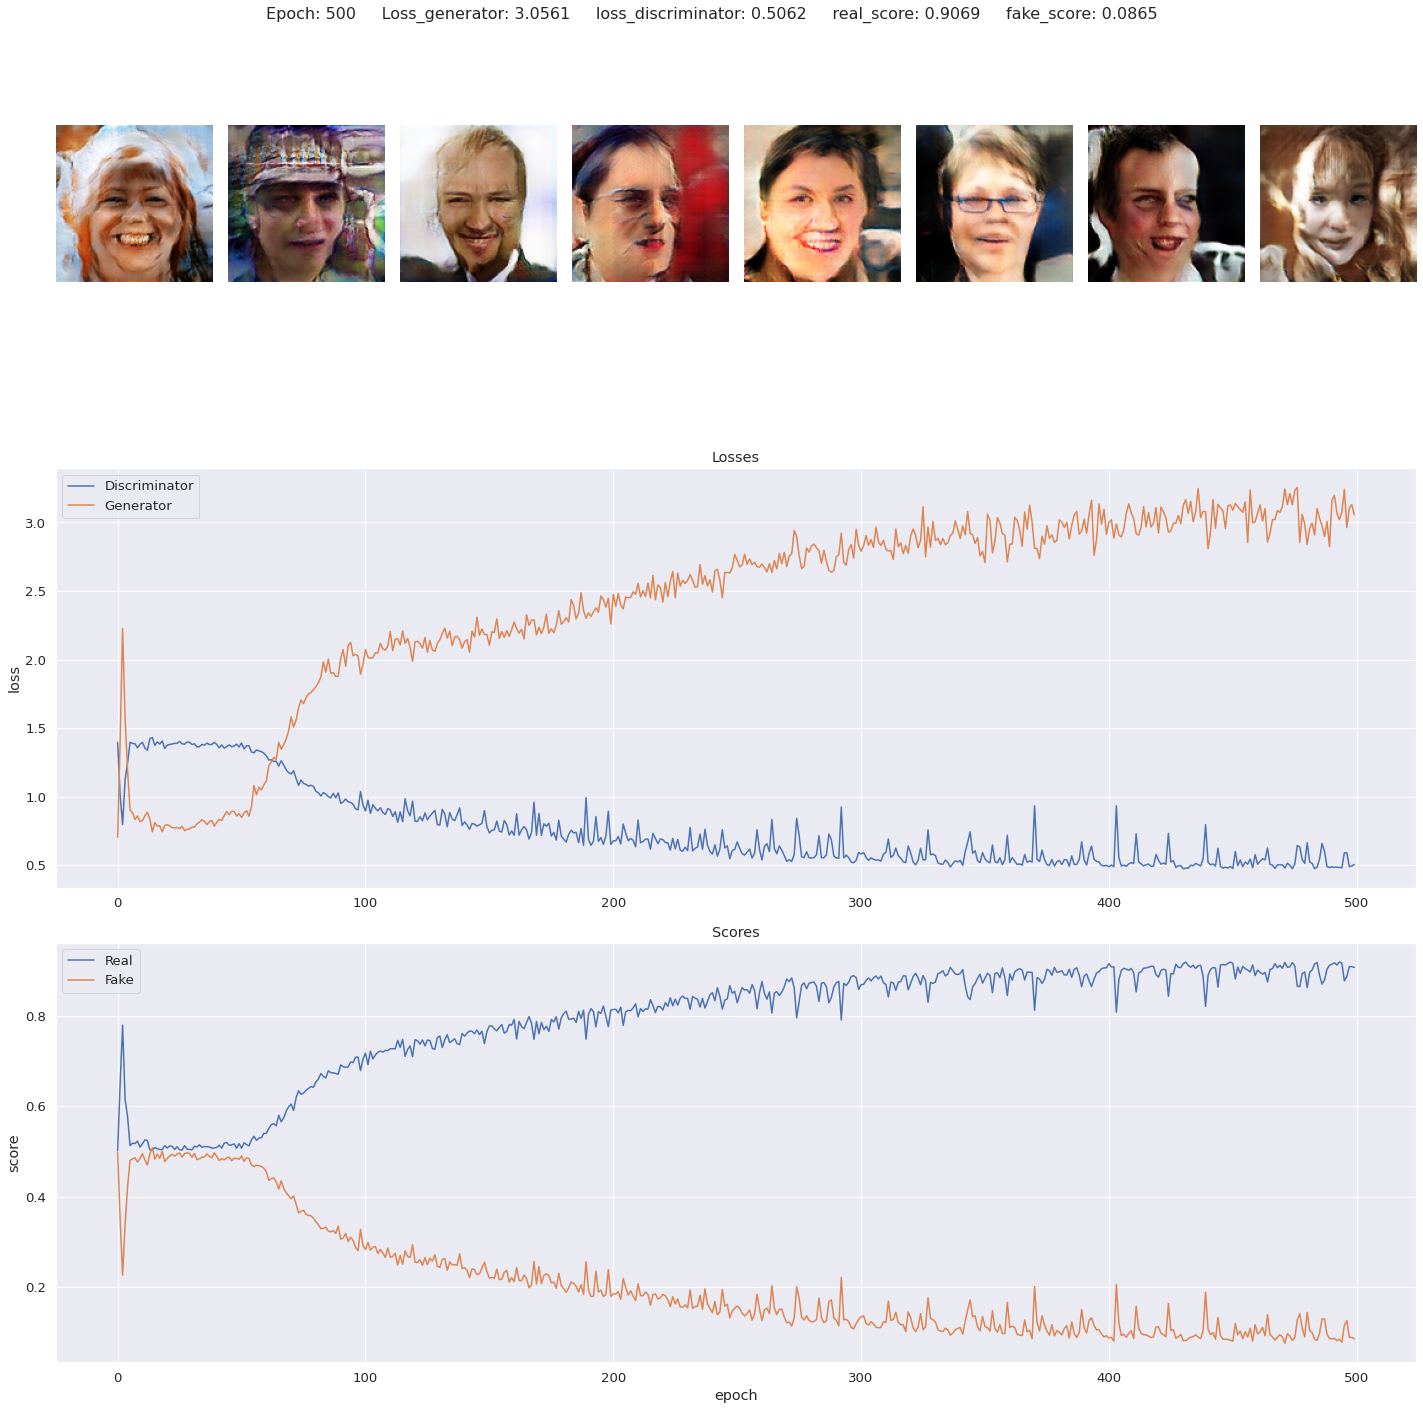

Epoch: 500/500 
Loss_generator: 3.0561, loss_discriminator: 0.5062, real_score: 0.9069, fake_score: 0.0865, time: 241.0


In [ ]:
EPOCHS = 500
m = fit(model, criterion, optimizer, EPOCHS, start_idx=1, smooth=0.1)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

*   **Первые 65-70 эпох классификатор побеждает генератор (скоры близки к 0.5).**

*   **Далее лоссы и скоры начинают расходиться: дискриминатор все лучше детектит фейки**
*   **В целом, картина похожа на те графики, которые были представлены на лекциях и в статьях по GAN-ам**

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

Сгенерируем 36 случайных векторов, подадим их в генератор и получим изображения

In [ ]:
n_images = 36

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

Функция для визуализации (масштабирование в аргументе)

In [ ]:
def show_images(generated, scale):
  with torch.no_grad():
    size = int(np.sqrt(len(generated)))
    fig, ax = plt.subplots(figsize=(size*scale, size*scale))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated).cpu().detach(), nrow=size).permute(1, 2, 0))

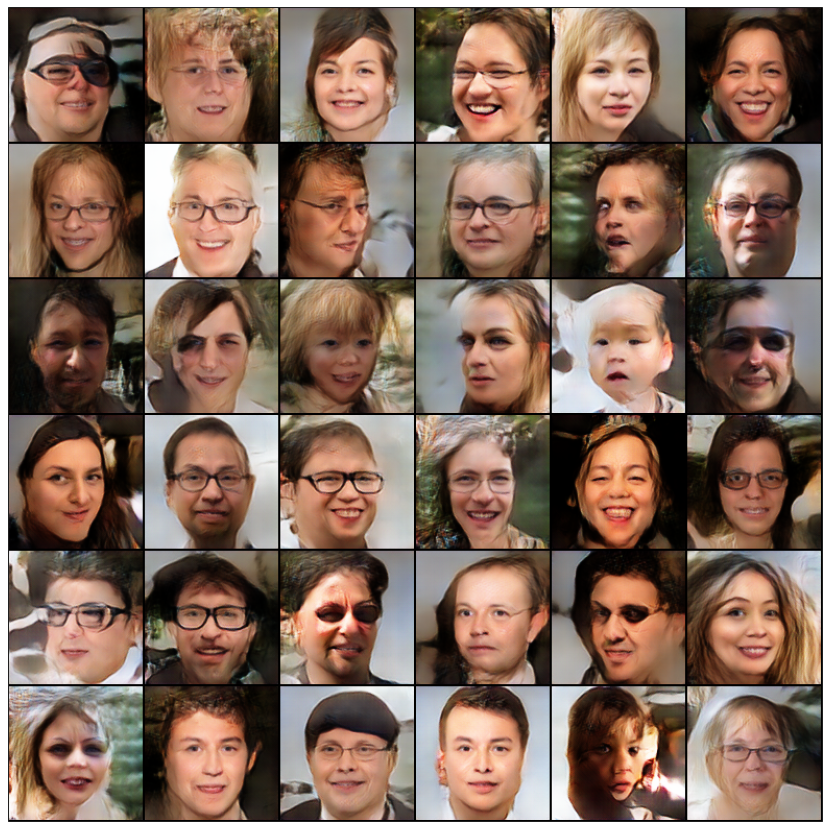

In [ ]:
show_images(fake_images, 2.5)

Как вам качество получившихся изображений?

**Чисто визуально, изображения получились не очень реалистичные. В некоторых случаях, как будто, малые части лица просто "срезаны", сливаясь с фоном. По самим лицам не всегда удается достоверно установить пол изображенного человека, некоторые лица внешне напоминают гибридов мужчины и женщины, парочка фото и вовсе комичны.**

**Однако есть пара-тройка фото, сгенерированных относительно хорошо. В основном все портят фон и волосы.**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Подгрузим веса последней эпохи

In [ ]:
generator = generator.to(DEVICE)
generator.load_state_dict(torch.load(os.path.join(M_WEIGHTS, 'm_gen_epoch_500.pth')))

<All keys matched successfully>

Создадим даталоадер и сгенерируем фейки

In [ ]:
# Количество изображений в датасете
num_imgs = len(preprocessed_files)
# Создаём такое же количество латентных векторов
fake_vecs = torch.randn(num_imgs, latent_size, 1, 1, device=DEVICE)
# Грузить будем даталоадером, всё целиком не влезет в память
fake_imgs_loader = DataLoader(fake_vecs, batch_size=64, shuffle=False)
fake_imgs_dev = DeviceDataLoader(fake_imgs_loader, DEVICE)
# Создаем пустой тензор, такого же размера как исходный датасет
fake_imgs = torch.empty_like(preprocessed_files)
# Генерируем изображения побатчево и заполняем тензор.
model['generator'].eval()
with torch.no_grad():
    for i,batch in enumerate(fake_imgs_dev):
        batch=batch.to(DEVICE)
        gen_imgs = model['generator'](batch)
        fake_imgs[i*len(batch):i*len(batch)+len(batch)] = gen_imgs
        batch.cpu()
        del batch
        torch.cuda.empty_cache()

Создадим метки и посчитаем KNN с количеством соседей, равным 1

In [ ]:
# Создаём метки для изображений(половина реальных - 1, половина фейковых - 0)
all_labels = torch.hstack((torch.ones(num_imgs), torch.zeros(num_imgs))).numpy()
# Объединяем все изображения, решейпим(вытягиваем каждое изображение в вектор)
all_imgs = torch.hstack((preprocessed_files, fake_imgs)).numpy().reshape(-1,128*128*3)

In [ ]:
# Считаем KNN, записываем реальные и предсказанные классы
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
loo = LeaveOneOut()
preds_list = []
classes_list = []
for train_idx, test_idx in loo.split(all_imgs):
    x_train, x_test = all_imgs[train_idx], all_imgs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    preds_list.append(y_pred)
    classes_list.append(y_test)

In [ ]:
# Запишем всё в датафрейм(так удобно потом будет фильтровать по классам)
loo_df = pd.DataFrame({'classes':np.array(classes_list).ravel(), 'preds': np.array(preds_list).ravel()})
loo_df.head()

,classes,preds
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0


Подсчитаем точность

In [ ]:
print(f'Общая accuracy: {accuracy_score(loo_df["classes"], loo_df["preds"])}')
print(f"Accuracy для реальных изображений: {accuracy_score(loo_df[loo_df['classes'] == 1].classes, loo_df[loo_df['classes'] == 1].preds)}")
print(f"Accuracy для фейковых изображений: {accuracy_score(loo_df[loo_df['classes'] == 0].classes, loo_df[loo_df['classes'] == 0].preds)}")

Общая accuracy: 0.5104995227489659
Accuracy для реальных изображений: 0.5011135857461024
Accuracy для фейковых изображений: 0.5198854597518294


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Целью было получить результат, близкий к 0.5, что характеризовало бы неспособность KNN классификатора отличить реальные изображения от сгенерированных. Собственно, и получили примерно такую точность, однако визуально сгенерированные картинки легко отличить от реальных.**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(all_imgs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
tsne_df = pd.DataFrame({'x':embedded[:,0], 'y':embedded[:,1], 'class':np.array(classes_list).ravel()})
tsne_df['class'] = tsne_df['class'].map({1:'real', 0:'fake'})
tsne_df.head()

,x,y,class
0,-29.235649,-6.074744,real
1,11.111650,-5.346167,real
2,-8.602051,35.703136,real
3,-3.505558,11.452105,real
4,3.835240,14.228885,real


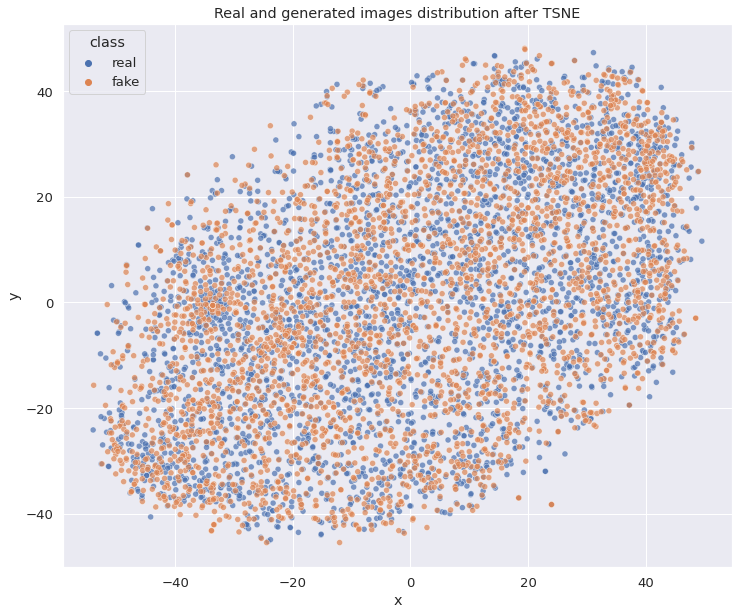

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='class', alpha=0.7)
plt.title('Real and generated images distribution after TSNE');

Прокомментируйте получившийся результат:

**По данному распределению практически нельзя визуально разделить реальные изображения и фейки. Это значит, что они очень похожи и, вероятно, мы генерируем изображения из того же распределения, что и реальные фото. К этому мы и стремились.**

**Собственно, результат устраивает, однако изображения в подавляющем большинстве случаев не слишком реалистичны. Очевидное предположение: для повышения реалистичности нужно использовать более сложные архитектуры.**